In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy import integrate
from scipy.optimize import minimize
import pickle
from timeit import default_timer as timer
import sys
import time
import multiprocessing as mp
import os
import pandas as pd
from requests import get
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami

# function for paramaters

In [2]:
#find the probability of successful disease transmission following a contact,
def find_transmission_probability(C, frac_sym, gammaA, gammaE, gammaH, gammaI, gammaP, \
              hosp_rate, redA, redH, redP, red_sus,  R0, totalPop):      
## （1）C：是一个矩阵，不同年龄的接触矩阵
## （2）frac_sym：是一个之后定义的参数，意义为会出现症状的比例。不同年龄不一样，在model图中等于1-a
## （3）gammaA,E,H,I,P都是常数，从文献得来.代表不同人群的恢复速率。=1/生病时长
## （4）hosp_rate,出现症状的人群中需要住院的比例，不同年龄有不同的比例，文中在从一个pickle文件里加载粗来了。
## （5）redA,H,P, red_sus ：常数，不同人群的感染力，文中直接给出了具体数字。
## （6） R0，常数，文中给出了具体数值3
## （7）totalPop

    [n1, n2] = np.shape(C)#年龄接触矩阵的形状,这里的n1和n2都等于16
    
# create F
    N = np.sum(totalPop)
    Z = np.zeros((n1, n1))
    C1 = np.zeros((n1, n1))
    for ivals in range(n1):
        for jvals in range(n1):
            C1[ivals, jvals] = red_sus[ivals] * C[ivals, jvals] * totalPop[ivals]/totalPop[jvals]
##red_sus[ivals]=reduction in susceptibility.不同年龄组不一样
## C[ivals, jvals]：年龄组为j和j的人群之间的接触率
## totalPop[ivals]：年龄组为i的人数
## totalPop[jvals]：年龄组为j的人数


    #create F by concatenating different matrices:
    F1 = np.concatenate((Z, redA*C1, redP*C1, C1, redH*C1), 1)##这里的1是axis=1的简写，
    F2 = np.zeros((4*n1, 5*n1))##创建了一个行为4*16，宽为5*16的全0矩阵

    F = np.concatenate((F1, F2), 0)

    #create V
    VgammaE = np.diag(gammaE * np.ones(n1))##取矩阵的对角线
    VgammaA = np.diag(gammaA * np.ones(n1))
    VgammaP = np.diag(gammaP * np.ones(n1))
    VgammaI = np.diag(gammaI * np.ones(n1))
    VgammaH = np.diag(gammaH * np.ones(n1))

    Vsub1 = np.diag(-(np.ones(n1)-frac_sym) * gammaE)
    Vsub2 = np.diag(-(frac_sym) * gammaE)

    Vsub3 = np.diag(-(np.ones(n1) - hosp_rate) * gammaP)
    Vsub4 = np.diag(-(hosp_rate) * gammaP)
    # print(V)

    V1 = np.concatenate((VgammaE, Z, Z, Z, Z), 1)
    V2 = np.concatenate((Vsub1, VgammaA, Z, Z, Z), 1)
    V3 = np.concatenate((Vsub2, Z, VgammaP, Z, Z), 1)
    V4 = np.concatenate((Z, Z, Vsub3, VgammaI, Z), 1)
    V5 = np.concatenate((Z, Z, Vsub4, Z, VgammaI), 1)

    V = np.concatenate((V1, V2, V3, V4, V5), 0)
    # print(np.linalg.inv(V))

    myProd = np.dot(F, np.linalg.inv(V))##Compute the (multiplicative) inverse of a matrix.
    # print(myProd)
    myEig = np.linalg.eig(myProd)##	 Compute the eigenvalues and right eigenvectors of a square array.
    # print(myEig)
    largestEig = np.max(myEig[0])
    if largestEig.imag == 0.0:##largestEig.imag得到largestEi这个数字的虚部，如果这个数字为0，说明这个数是实数。

        transmission_probability = R0 / largestEig.real##返回复杂参数的实部。

        return transmission_probability
    else:
        print(largestEig)
        raise Exception('largest eigenvalue is not real')

# unchanged paramaters

In [3]:
# Scotland population
N=5463300

In [4]:
#UK contact matrix
myfilename = r'C:\Users\Mardo\Desktop\COVID-19 model\data\UK_consistent_matrix.pickle'
f=open(myfilename,'rb')
UK_consistent_matrix=pickle.load(f)
f.close()
#print(UK_consistent_matrix)

In [5]:
#Scottish age fractions 
myfilename = r'C:\Users\Mardo\Desktop\COVID-19 model\data\Scottish_fraction_16groups.pickle'
f=open(myfilename,'rb')
population16_fractions=pickle.load(f)
f.close()
#print(population16_fractions)

In [6]:
# scottish popluation by age
population_16groups=N*population16_fractions

In [7]:
population_16groups

array([271715., 299316., 294674., 281958., 347456., 382255., 369463.,
       352522., 319432., 361458., 401090., 393123., 344693., 299444.,
       278856., 465845.])

In [8]:
population16_fractions*30000

array([1492.03777936, 1643.60002196, 1618.10993356, 1548.28400417,
       1907.94574708, 2099.03355115, 2028.79029158, 1935.76409862,
       1754.06073252, 1984.83334249, 2202.46005162, 2158.71176761,
       1892.77359837, 1644.30289386, 1531.2503432 , 2558.04184284])

In [9]:
# number of age groups
number_of_AgeGroups=16

In [10]:
# scottish hospital rate by age group
myfilename = r'C:\Users\Mardo\Desktop\COVID-19 model\data\scottish_hosp_rate.pickle'
f=open(myfilename,'rb')
hosp_rate_16=pickle.load(f)
f.close()
nonHospRate = np.ones(number_of_AgeGroups) - hosp_rate_16

In [11]:
# death rate by age
myfilename = r'C:\Users\Mardo\Desktop\COVID-19 model\data\scottish_death_rate.pickle'
f=open(myfilename,'rb')
scottish_death_rate16=pickle.load(f)
f.close()
death_rate16=scottish_death_rate16
death_rate16

array([0.00420168, 0.01342282, 0.01342282, 0.11286089, 0.0577957 ,
       0.02392877, 0.02392877, 0.02392877, 0.02392877, 0.14741148,
       0.14741148, 0.14741148, 0.14741148, 0.34993695, 0.34993695,
       0.74081942])

In [12]:
#time horizon for the intervention:
tspan = np.linspace(0, 365, 365 * 2)

In [13]:
#fraction of symptomatic and asymptomatic people
general_frac_asymptomatic = 0.35
frac_symptomatic = (1 - general_frac_asymptomatic) * np.ones(16)  # fraction of infected that are symptomatic
frac_symptomatic[0:4] = 0.2
frac_asymptomatic=np.ones(16) - frac_symptomatic

In [14]:
#transition rates:
durI = 3  # duration of infectiousness after developing symptoms
durP = 2  # duration of infectiousness before developing symptoms
durA = durI + durP  # the duration of asymptomatic infections is equal to that of symptomatic infections
gammaA = 1 / durA  # recovery rate for asymptomatic
gammaH = 1 / 5  # recovery rate for hospitalizations 
gammaI = 1 / durI  # recovery rate for symptomatic infections (not hospitalized)
gammaP = 1 / durP  # transition rate fromm pre-symptomatic to symptomatic
gammaE = 1 / 3  # transition rate from exposed to infectiousb

In [15]:
#reduction/increase of infectiousness
redA = 1  # reduction of infectiousness for asymptomatic infections
redH = 0.  # reduction of infectiousness for hospitalized infections
redP = 1.3  # this makes the fraction of infections attributed to pre-sym cases roughly equal to 40% at the peak for 2< R0<3

In [16]:
#reduction in susceptibility: taken from Zhang, Science 2020
red_sus = np.ones(16)
red_sus[0:3] = 0.34
red_sus[3:13] = 1
red_sus[13:16] = 1.47

In [17]:
# Disease severity
R0 = 3

In [18]:
# compute beta based on these parameters:
transmission_probability = find_transmission_probability(UK_consistent_matrix, frac_symptomatic, gammaA, gammaE, gammaH, gammaI, gammaP, hosp_rate_16, redA, redH, redP, red_sus,  R0, population_16groups)
#print(transmission_probability)

In [19]:
#fraction of the population assumed to be immune at the beginning of vaccination
frac_preimmuned = 0.2

In [20]:
#number of current infections:
currentInfections = 1000*population16_fractions

In [21]:
# get initial condition by age group
S0 = (1 - frac_preimmuned) * (population_16groups - currentInfections)
I0 = frac_symptomatic * currentInfections
E0 = np.zeros(number_of_AgeGroups)
A0 = frac_asymptomatic * currentInfections
P0 = np.zeros(number_of_AgeGroups)
H0 = np.zeros(number_of_AgeGroups)
Rec0 = np.multiply(frac_symptomatic * frac_preimmuned * (population_16groups - currentInfections), nonHospRate)
RecA0 =frac_asymptomatic* frac_preimmuned * (population_16groups - currentInfections)
RecH0 = np.multiply(frac_symptomatic *frac_preimmuned * (population_16groups - currentInfections),hosp_rate_16)
D0=np.zeros(number_of_AgeGroups)
Cases0 = np.copy(I0) + np.copy(A0)
D_V0=np.zeros(number_of_AgeGroups)

In [22]:
S_V0,E_V0, A_V0, P_V0, I_V0, H_V0, RecV_0, RecAV_0, RecHV_0=np.zeros(number_of_AgeGroups), np.zeros(number_of_AgeGroups), \
                                                            np.zeros(number_of_AgeGroups), np.zeros(number_of_AgeGroups), \
                                                            np.zeros(number_of_AgeGroups), np.zeros(number_of_AgeGroups), \
                                                            np.zeros(number_of_AgeGroups), np.zeros(number_of_AgeGroups), \
                                                            np.zeros(number_of_AgeGroups)

In [23]:
y0 = np.array([S0, E0, A0, P0, I0, H0, Rec0, RecA0, RecH0,\
               S_V0, E_V0, A_V0, P_V0, I_V0, H_V0, RecV_0, RecAV_0, RecHV_0,Cases0,D0,D_V0]).reshape((21*number_of_AgeGroups))

#print(y0)

In [24]:
contact_rate16 = np.sum(UK_consistent_matrix,axis=1)
beta=contact_rate16*transmission_probability

# function for model

In [81]:
def equation_with_vaccination (y, tspan,transmission_probability,beta,frac_symptomatic, gammaA, gammaE, gammaH, gammaI, gammaP,hosp_rate_16, number_of_AgeGroups,\
    frac_asymptomatic, redA, redH,redP, red_sus,population_16groups,vaccineSpeed,VE,death_rate16,vaccinecoverage):
    
    temp = np.reshape(y, (21, 16))
    S = temp[0, :]  #susceptibles
    E = temp[1, :]  #Exposed
    A = temp[2, :]  #Asymptomatic infected
    P = temp[3, :]  # Pre-symptomatic infected
    I = temp[4, :]  #Symptomatic infe11,12cted
    H = temp[5, :]  #Hospitalized non ICU
    R = temp[6, :]  #Recovered symptomatic
    RA = temp[7, :] #Recovered Asymptomatic
    RH = temp[8, :] #recovered hospitalized
    D=temp[19,:]
    
    S_V = temp[9, :]  # suscepAtibles vaccinated
    E_V = temp[10, :]  # Exposed vaccinated
    A_V = temp[11, :]  # Asymptomatic infected vaccinated
    P_V = temp[12, :]  # Pre-symptomatic infected vaccinated
    I_V = temp[13, :]  # Symptomatic infected vaccinated
    H_V = temp[14, :]  # Hospitalizes symptomatic infected vaccinated
    R_V = temp[15, :]  # Recovered symptomatic vaccinated
    RA_V = temp[16, :]  # Recovered Asymptomatic vaccinated
    RH_V =temp[17,:] #Recovered Hospitalized vaccinated
    D_V=temp[20,:]
    totalInf = temp[18, :]   #total cummulative infections
    
    # get force of infection（lambda：λ）
    mylambda_step1=np.divide((redA * (A + A_V) +redP * (P + P_V) +redH * (H + H_V) +(I + I_V)), population_16groups-D)
    mylambda = np.multiply(beta,mylambda_step1)
    
    newpopulation_16groups=population_16groups
    newN=N-np.sum(D)
    S_fract=np.divide(np.sum(S),np.sum(newpopulation_16groups) )
    
    if vaccineSpeed*tspan>newN*vaccinecoverage:
        vaccineSpeed=0
    
    
    dS = - np.multiply(mylambda, S)-vaccineSpeed*S/newN
    dE = np.multiply(mylambda, S) - gammaE * E
    dA = gammaE * np.multiply(E, frac_asymptomatic) - gammaA * A
    dP = gammaE * np.multiply(E, frac_symptomatic) - gammaP * P
    dI = gammaP * np.multiply(P, nonHospRate) - gammaI * I
    dH = gammaP * np.multiply(P, hosp_rate_16) - gammaH * H-np.multiply(death_rate16,H)
    dR = gammaI * I
    dRA = gammaA * A
    dRH = gammaH * H
    dD=np.multiply(death_rate16,H)
        
    dS_V = - (1 - VE) * np.multiply(mylambda, S_V)+vaccineSpeed*S/newN
    dE_V = (1 - VE) * np.multiply(mylambda, S_V) - gammaE * E_V
    dA_V = gammaE * np.multiply(E_V, frac_asymptomatic) - gammaA * A_V   
    dP_V = gammaE * np.multiply(E_V, frac_symptomatic) - gammaP * P_V
    dI_V = gammaP * np.multiply(P_V, nonHospRate) - gammaI * I_V
    dH_V = gammaP * np.multiply(P_V, hosp_rate_16) - gammaH * H_V-np.multiply(death_rate16,H_V)
    dR_V = gammaI * I_V
    dRA_V = gammaA * A_V
    dRH_V = gammaH * H_V      
    dD_V=np.multiply(death_rate16,H_V)
    
    dtotalInf = -(dS+dS_V)

    dydt = np.array([dS, dE, dA, dP, dI, dH, dR, dRA, dRH,dS_V, dE_V, dA_V, dP_V, dI_V, dH_V, dR_V, dRA_V, dRH_V, dtotalInf, dD,dD_V]).reshape((16 * 21))
   
    return dydt

# total death under varying vaccine coverage

In [78]:
total_Death=np.zeros((730,10))
totald_Death=np.zeros((730,10))

for i in range(1,11):
# get vaccination coverage
    vaccinecoverage=i/10
    
#get VE and Vaccin speed for no delay vaccine strategy,and get results
    vaccinespeed=15000
    VE=0.9
    output= odeint(equation_with_vaccination, y0, tspan, args=(transmission_probability,beta,frac_symptomatic, gammaA, gammaE, gammaH, gammaI, gammaP,hosp_rate_16, number_of_AgeGroups,\
    frac_asymptomatic, redA, redH,redP, red_sus,population_16groups,vaccineSpeed,VE,death_rate16,vaccinecoverage))
# calculated total death for no delay vaccine strategy
    total_D=output[:,304:320]
    total_DV=output[:,320:336]
    total_D_and_DV=np.sum(total_D,axis=1)+np.sum(total_DV,axis=1)
    total_D_and_DV=total_D_and_DV.astype('int')
    total_Death[:,i-1]=total_D_and_DV

#get VE and Vaccin speed for no delay vaccine strategy,and get results
    vaccineSpeed_delay=30000
    VE_D=0.5
    output2= odeint(equation_with_vaccination, y0, tspan, args=(transmission_probability,beta,frac_symptomatic, gammaA, gammaE, gammaH, gammaI, gammaP,hosp_rate_16, number_of_AgeGroups,\
    frac_asymptomatic, redA, redH,redP, red_sus,population_16groups,vaccineSpeed_delay,VE_D,death_rate16,vaccinecoverage))
# calculated total death for no delay vaccine strategy
    totald_D=output2[:,304:320]
    totald_DV=output2[:,320:336]
    totald_D_and_DV=np.sum(totald_D,axis=1)+np.sum(totald_DV,axis=1)
    totald_D_and_DV=totald_D_and_DV.astype('int')
    totald_Death[:,i-1]=totald_D_and_DV

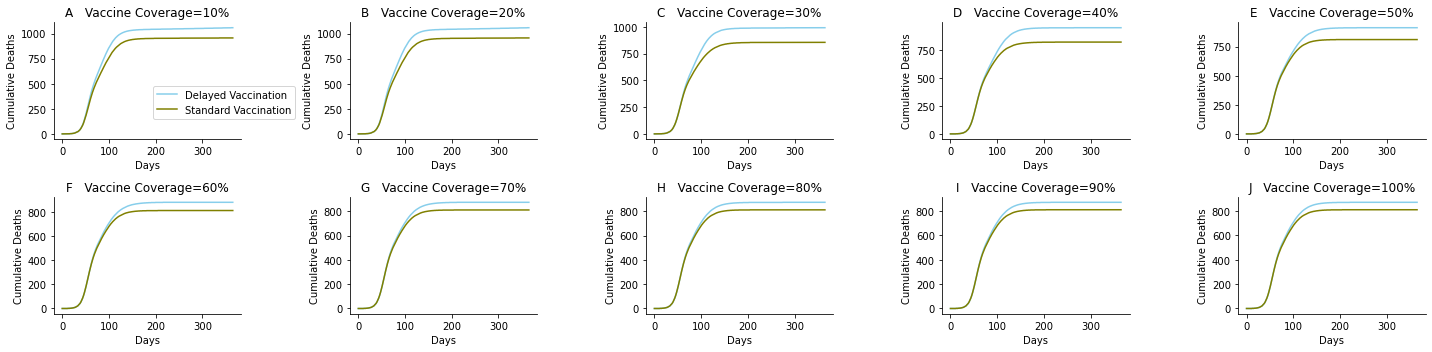

In [79]:
fig = plt.figure(tight_layout=True,figsize=(20,5))
gs = gridspec.GridSpec(2, 5)
alpha=['A','B','C','D','E','F','G','H','I','J']

for i in range(5):
    VE="%.f%%" % ((i+1) * 10)
    ax = fig.add_subplot(gs[0, i])
    if i==0:
        ax.plot(tspan, totald_Death[:,i],color='skyblue',label="Delayed Vaccination")
        ax.plot(tspan, total_Death[:,i],color='olive',label="Standard Vaccination")
        plt.legend(loc=0, bbox_to_anchor=(0.5, 0.5))
    else:
        ax.plot(tspan, totald_Death[:,i-1],color='skyblue')
        ax.plot(tspan, total_Death[:,i-1],color='olive')
    ax.set_ylabel('Cumulative Deaths')
    ax.set_xlabel('Days')
    ax.set_title(alpha[i]+"   Vaccine Coverage="+VE)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

for i in range(5):
    VE="%.f%%" % ((i+6) * 10)
    ax = fig.add_subplot(gs[1, i])
    ax.plot(tspan, totald_Death[:,i+5],color='skyblue')
    ax.plot(tspan, total_Death[:,i+5],color='olive')
    ax.set_ylabel('Cumulative Deaths')
    ax.set_xlabel('Days')
    ax.set_title(alpha[i+5]+"   Vaccine Coverage="+VE)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
plt.show()

# total infectious under varying first dose vaccine efficacy

In [127]:
total_Infectious=np.zeros((730,10))
totald_Infectious=np.zeros((730,10))
final_Infectious=np.zeros(10)
finald_Infectious=np.zeros(10)
vaccinecoverage=0.8

for i in range(1,11):
# get vaccination coverage
    VE_D=i/10
    
#get VE and Vaccin speed for no delay vaccine strategy,and get results
    vaccineSpeed=15000
    VE=0.9
    output= odeint(equation_with_vaccination, y0, tspan, args=(transmission_probability,beta,frac_symptomatic, gammaA, gammaE, gammaH, gammaI, gammaP,hosp_rate_16, number_of_AgeGroups,\
    frac_asymptomatic, redA, redH,redP, red_sus,population_16groups,vaccineSpeed,VE,death_rate16,vaccinecoverage))
# calculated total infectious for no delay vaccine strategy
    total_inf=output[:,288:304]
    sum_inf=np.sum(total_inf,axis=1)
    sum_inf=sum_inf.astype('int')
    total_Infectious[:,i-1]=sum_inf
    final_Infectious[i-1]=np.max(total_Infectious[:,i-1])

#get VE and Vaccin speed for no delay vaccine strategy,and get results
    vaccineSpeed_delay=30000
    output2= odeint(equation_with_vaccination, y0, tspan, args=(transmission_probability,beta,frac_symptomatic, gammaA, gammaE, gammaH, gammaI, gammaP,hosp_rate_16, number_of_AgeGroups,\
    frac_asymptomatic, redA, redH,redP, red_sus,population_16groups,vaccineSpeed_delay,VE_D,death_rate16,vaccinecoverage))
# calculated total infectious for no delay vaccine strategy
    totald_inf=output2[:,288:304]
    sumd_inf=np.sum(totald_inf,axis=1)
    sumd_inf=sumd_inf.astype('int')
    totald_Infectious[:,i-1]=sumd_inf
    finald_Infectious[i-1]=np.max(totald_Infectious[:,i-1])
print(final_Infectious)
print('*********************************************')
print(finald_Infectious)

[2216640. 2216640. 2216640. 2216640. 2216640. 2216640. 2216640. 2216640.
 2216640. 2216640.]
*********************************************
[2734771. 2660338. 2577347. 2477421. 2360556. 2229806. 2082868. 1918788.
 1741602. 1557825.]


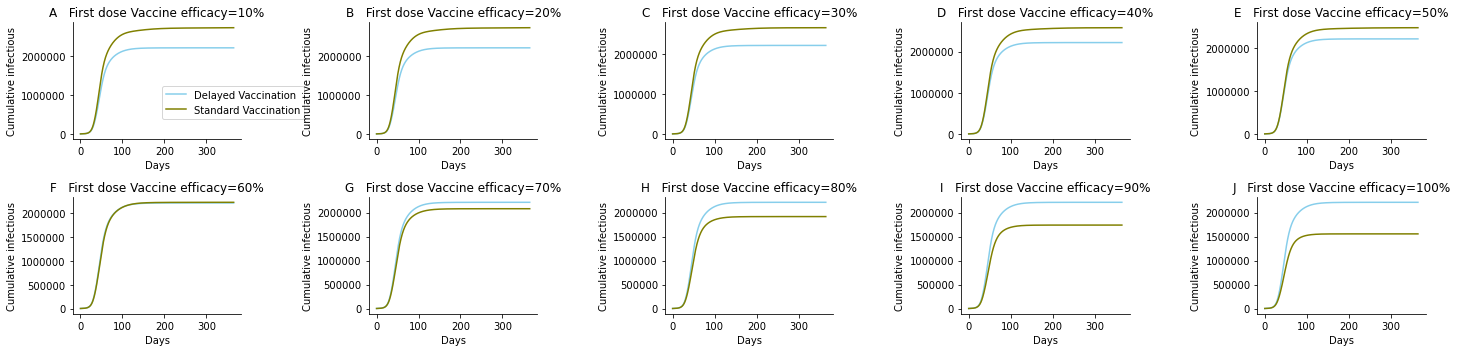

In [128]:
fig = plt.figure(tight_layout=True,figsize=(20,5))
gs = gridspec.GridSpec(2, 5)
alpha=['A','B','C','D','E','F','G','H','I','J']

for i in range(5):
    VE="%.f%%" % ((i+1) * 10)
    ax = fig.add_subplot(gs[0, i])
    if i==0:
        ax.plot(tspan, total_Infectious[:,i],color='skyblue',label="Delayed Vaccination")
        ax.plot(tspan, totald_Infectious[:,i],color='olive',label="Standard Vaccination")
        plt.legend(loc=0, bbox_to_anchor=(0.5, 0.5))
    else:
        ax.plot(tspan, total_Infectious[:,i-1],color='skyblue')
        ax.plot(tspan, totald_Infectious[:,i-1],color='olive')
    ax.set_ylabel('Cumulative infectious')
    ax.set_xlabel('Days')
    ax.set_title(alpha[i]+"   First dose Vaccine efficacy="+VE)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.get_yaxis().get_major_formatter().set_scientific(False) 

for i in range(5):
    VE="%.f%%" % ((i+6) * 10)
    ax = fig.add_subplot(gs[1, i])
    ax.plot(tspan, total_Infectious[:,i+5],color='skyblue')
    ax.plot(tspan, totald_Infectious[:,i+5],color='olive')
    ax.set_ylabel('Cumulative infectious')
    ax.set_xlabel('Days')
    ax.set_title(alpha[i+5]+"   First dose Vaccine efficacy="+VE)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.get_yaxis().get_major_formatter().set_scientific(False) 
    
plt.show()

# total death under varying firs dose efficacy

In [82]:
total_Death=np.zeros((730,10))
totald_Death=np.zeros((730,10))
final_death=np.zeros(10)
finald_death=np.zeros(10)
vaccinecoverage=0.8

for i in range(1,11):
# get vaccination coverage
    VE_D=i/10
    
#get VE and Vaccin speed for no delay vaccine strategy,and get results
    vaccineSpeed=15000
    VE=0.9
    output= odeint(equation_with_vaccination, y0, tspan, args=(transmission_probability,beta,frac_symptomatic, gammaA, gammaE, gammaH, gammaI, gammaP,hosp_rate_16, number_of_AgeGroups,\
    frac_asymptomatic, redA, redH,redP, red_sus,population_16groups,vaccineSpeed,VE,death_rate16,vaccinecoverage))
# calculated total death for no delay vaccine strategy
    total_D=output[:,304:320]
    total_DV=output[:,320:336]
    total_D_and_DV=np.sum(total_D,axis=1)+np.sum(total_DV,axis=1)
    total_D_and_DV=total_D_and_DV.astype('int')
    total_Death[:,i-1]=total_D_and_DV
    final_death[i-1]=np.max(total_Death[:,i-1])

#get VE and Vaccin speed for no delay vaccine strategy,and get results
    vaccineSpeed_delay=30000
    output2= odeint(equation_with_vaccination, y0, tspan, args=(transmission_probability,beta,frac_symptomatic, gammaA, gammaE, gammaH, gammaI, gammaP,hosp_rate_16, number_of_AgeGroups,\
    frac_asymptomatic, redA, redH,redP, red_sus,population_16groups,vaccineSpeed_delay,VE_D,death_rate16,vaccinecoverage))
# calculated total death for no delay vaccine strategy
    totald_D=output2[:,304:320]
    totald_DV=output2[:,320:336]
    totald_D_and_DV=np.sum(totald_D,axis=1)+np.sum(totald_DV,axis=1)
    totald_D_and_DV=totald_D_and_DV.astype('int')
    totald_Death[:,i-1]=totald_D_and_DV
    finald_death[i-1]=np.max(totald_Death[:,i-1])

print(final_death)
print(finald_death)

[811. 811. 811. 811. 811. 811. 811. 811. 811. 811.]
[1089. 1037.  991.  937.  873.  797.  714.  626.  541.  464.]


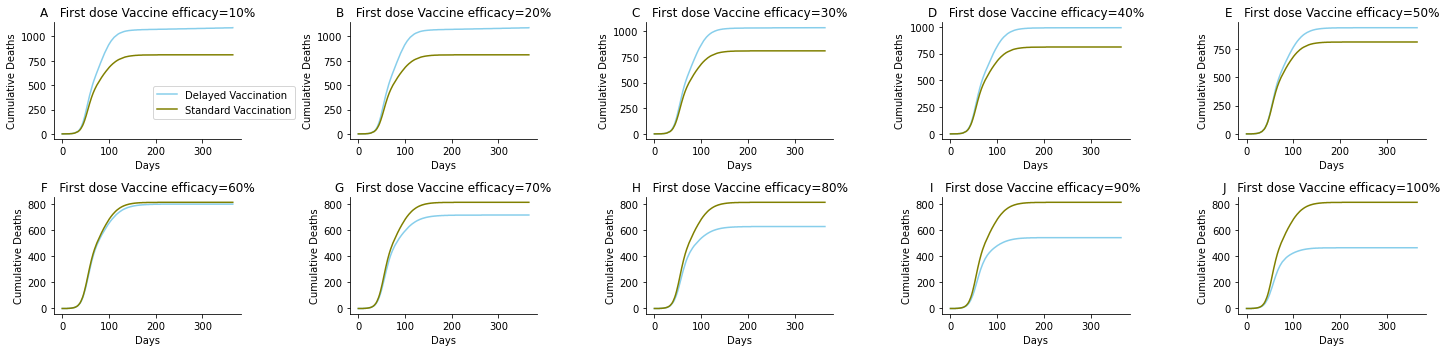

In [83]:
fig = plt.figure(tight_layout=True,figsize=(20,5))
gs = gridspec.GridSpec(2, 5)
alpha=['A','B','C','D','E','F','G','H','I','J']

for i in range(5):
    VE="%.f%%" % ((i+1) * 10)
    ax = fig.add_subplot(gs[0, i])
    if i==0:
        ax.plot(tspan, totald_Death[:,i],color='skyblue',label="Delayed Vaccination")
        ax.plot(tspan, total_Death[:,i],color='olive',label="Standard Vaccination")
        plt.legend(loc=0, bbox_to_anchor=(0.5, 0.5))
    else:
        ax.plot(tspan, totald_Death[:,i-1],color='skyblue')
        ax.plot(tspan, total_Death[:,i-1],color='olive')
    ax.set_ylabel('Cumulative Deaths')
    ax.set_xlabel('Days')
    ax.set_title(alpha[i]+"   First dose Vaccine efficacy="+VE)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.get_yaxis().get_major_formatter().set_scientific(False)

for i in range(5):
    VE="%.f%%" % ((i+6) * 10)
    ax = fig.add_subplot(gs[1, i])
    ax.plot(tspan, totald_Death[:,i+5],color='skyblue')
    ax.plot(tspan, total_Death[:,i+5],color='olive')
    ax.set_ylabel('Cumulative Deaths')
    ax.set_xlabel('Days')
    ax.set_title(alpha[i+5]+"   First dose Vaccine efficacy="+VE)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.get_yaxis().get_major_formatter().set_scientific(False)
plt.show()

# total hostiptal cases under varying first dose vaccine efficacy

In [133]:
total_Hosp=np.zeros((730,10))
totald_Hosp=np.zeros((730,10))
final_Hosp=np.zeros(10)
finald_Hosp=np.zeros(10)
vaccinecoverage=0.8

for i in range(1,11):
# get vaccination coverage
    VE_H=i/10
    
#get VE and Vaccin speed for no delay vaccine strategy,and get results
    vaccineSpeed=15000
    VE=0.9
    output= odeint(equation_with_vaccination, y0, tspan, args=(transmission_probability,beta,frac_symptomatic, gammaA, gammaE, gammaH, gammaI, gammaP,hosp_rate_16, number_of_AgeGroups,\
    frac_asymptomatic, redA, redH,redP, red_sus,population_16groups,vaccineSpeed,VE,death_rate16,vaccinecoverage))
# calculated total death for no delay vaccine strategy
    total_H=output[:,80:96]
    total_HV=output[:,224:240]
    total_H_and_HV=np.sum(total_H,axis=1)+np.sum(total_HV,axis=1)
    total_H_and_HV=total_H_and_HV.astype('int')
    total_Hosp[:,i-1]=total_H_and_HV
    final_Hosp[i-1]=np.max(total_Hosp[:,i-1])

#get VE and Vaccin speed for no delay vaccine strategy,and get results
    vaccineSpeed_delay=30000
    output2= odeint(equation_with_vaccination, y0, tspan, args=(transmission_probability,beta,frac_symptomatic, gammaA, gammaE, gammaH, gammaI, gammaP,hosp_rate_16, number_of_AgeGroups,\
    frac_asymptomatic, redA, redH,redP, red_sus,population_16groups,vaccineSpeed_delay,VE_H,death_rate16,vaccinecoverage))
# calculated total death for no delay vaccine strategy
    totald_H=output2[:,80:96]
    totald_HV=output2[:,224:240]
    totald_H_and_HV=np.sum(totald_H,axis=1)+np.sum(totald_HV,axis=1)
    totald_H_and_HV=totald_H_and_HV.astype('int')
    totald_Hosp[:,i-1]=totald_H_and_HV
    finald_Hosp[i-1]=np.max(totald_Hosp[:,i-1])

print(final_Hosp)
print(finald_Hosp)

[251. 251. 251. 251. 251. 251. 251. 251. 251. 251.]
[309. 298. 286. 273. 259. 244. 227. 210. 191. 173.]


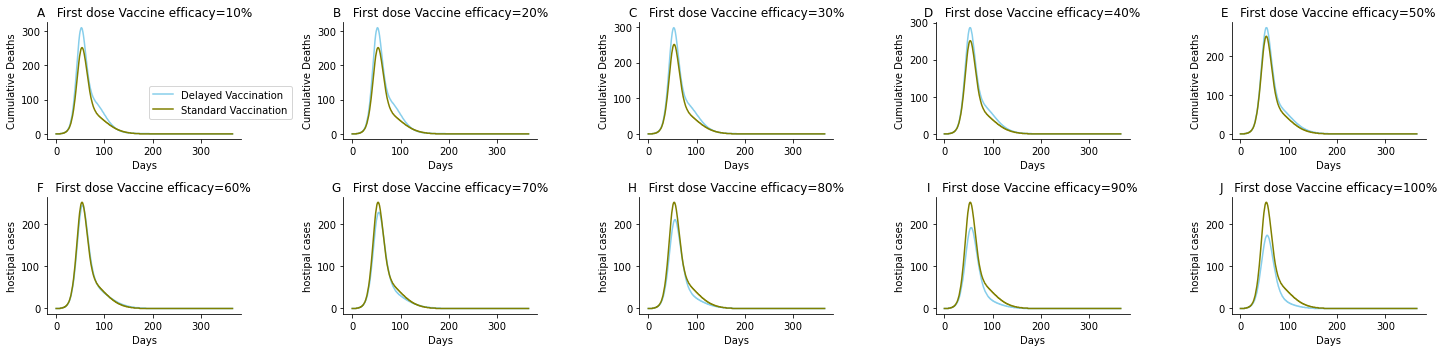

In [134]:
fig = plt.figure(tight_layout=True,figsize=(20,5))
gs = gridspec.GridSpec(2, 5)
alpha=['A','B','C','D','E','F','G','H','I','J']

for i in range(5):
    VE="%.f%%" % ((i+1) * 10)
    ax = fig.add_subplot(gs[0, i])
    if i==0:
        ax.plot(tspan, totald_Hosp[:,i],color='skyblue',label="Delayed Vaccination")
        ax.plot(tspan, total_Hosp[:,i],color='olive',label="Standard Vaccination")
        plt.legend(loc=0, bbox_to_anchor=(0.5, 0.5))
    else:
        ax.plot(tspan, totald_Hosp[:,i-1],color='skyblue')
        ax.plot(tspan, total_Hosp[:,i-1],color='olive')
    ax.set_ylabel('Cumulative Deaths')
    ax.set_xlabel('Days')
    ax.set_title(alpha[i]+"   First dose Vaccine efficacy="+VE)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.get_yaxis().get_major_formatter().set_scientific(False)

for i in range(5):
    VE="%.f%%" % ((i+6) * 10)
    ax = fig.add_subplot(gs[1, i])
    ax.plot(tspan, totald_Hosp[:,i+5],color='skyblue')
    ax.plot(tspan, total_Hosp[:,i+5],color='olive')
    ax.set_ylabel('hostipal cases')
    ax.set_xlabel('Days')
    ax.set_title(alpha[i+5]+"   First dose Vaccine efficacy="+VE)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.get_yaxis().get_major_formatter().set_scientific(False)
plt.show()

# total death under varying preimmuned fractions

In [75]:
total_Death=np.zeros((730,10))
totald_Death=np.zeros((730,10))
vaccinecoverage=0.3

for i in range(1,11):
# get vaccination coverage
    frac_preimmuned = i/10
    
    S0 = (1 - frac_preimmuned) * (population_16groups - currentInfections)
    I0 = frac_symptomatic * currentInfections
    E0 = np.zeros(number_of_AgeGroups)
    A0 = frac_asymptomatic * currentInfections
    P0 = np.zeros(number_of_AgeGroups)
    H0 = np.zeros(number_of_AgeGroups)
    Rec0 = np.multiply(frac_symptomatic * frac_preimmuned * (population_16groups - currentInfections), nonHospRate)
    RecA0 =frac_asymptomatic* frac_preimmuned * (population_16groups - currentInfections)
    RecH0 = np.multiply(frac_symptomatic *frac_preimmuned * (population_16groups - currentInfections),hosp_rate_16)
    D0=np.zeros(number_of_AgeGroups)
    Cases0 = np.copy(I0) + np.copy(A0)
    D_V0=np.zeros(number_of_AgeGroups)
    S_V0,E_V0, A_V0, P_V0, I_V0, H_V0, RecV_0, RecAV_0, RecHV_0=np.zeros(number_of_AgeGroups), np.zeros(number_of_AgeGroups), \
                                                            np.zeros(number_of_AgeGroups), np.zeros(number_of_AgeGroups), \
                                                            np.zeros(number_of_AgeGroups), np.zeros(number_of_AgeGroups), \
                                                            np.zeros(number_of_AgeGroups), np.zeros(number_of_AgeGroups), \
                                                            np.zeros(number_of_AgeGroups)
    y0 = np.array([S0, E0, A0, P0, I0, H0, Rec0, RecA0, RecH0,\
               S_V0, E_V0, A_V0, P_V0, I_V0, H_V0, RecV_0, RecAV_0, RecHV_0,Cases0,D0,D_V0]).reshape((21*number_of_AgeGroups))

#print(y0)
    
#get VE and Vaccin speed for no delay vaccine strategy,and get results
    vaccinespeed=15000
    VE=0.9
    output= odeint(equation_with_vaccination, y0, tspan, args=(transmission_probability,beta,frac_symptomatic, gammaA, gammaE, gammaH, gammaI, gammaP,hosp_rate_16, number_of_AgeGroups,\
    frac_asymptomatic, redA, redH,redP, red_sus,population_16groups,vaccineSpeed,VE,death_rate16,vaccinecoverage))
# calculated total death for no delay vaccine strategy
    total_D=output[:,304:320]
    total_DV=output[:,320:336]
    total_D_and_DV=np.sum(total_D,axis=1)+np.sum(total_DV,axis=1)
    total_D_and_DV=total_D_and_DV.astype('int')
    total_Death[:,i-1]=total_D_and_DV

#get VE and Vaccin speed for no delay vaccine strategy,and get results
    vaccineSpeed_delay=30000
    output2= odeint(equation_with_vaccination, y0, tspan, args=(transmission_probability,beta,frac_symptomatic, gammaA, gammaE, gammaH, gammaI, gammaP,hosp_rate_16, number_of_AgeGroups,\
    frac_asymptomatic, redA, redH,redP, red_sus,population_16groups,vaccineSpeed_delay,VE_D,death_rate16,vaccinecoverage))
# calculated total death for no delay vaccine strategy
    totald_D=output2[:,304:320]
    totald_DV=output2[:,320:336]
    totald_D_and_DV=np.sum(totald_D,axis=1)+np.sum(totald_DV,axis=1)
    totald_D_and_DV=totald_D_and_DV.astype('int')
    totald_Death[:,i-1]=totald_D_and_DV

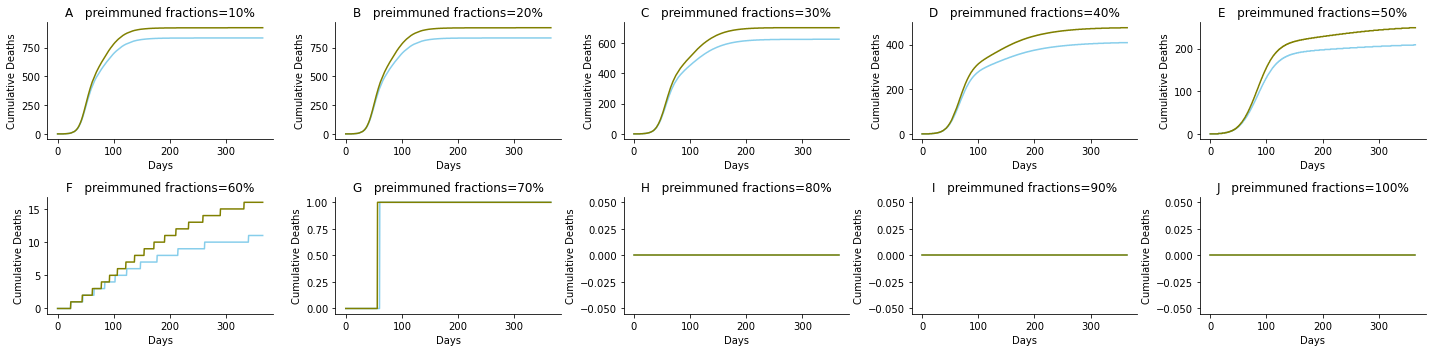

In [76]:
fig = plt.figure(tight_layout=True,figsize=(20,5))
gs = gridspec.GridSpec(2, 5)
alpha=['A','B','C','D','E','F','G','H','I','J']
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height

for i in range(5):
    VE="%.f%%" % ((i+1) * 10)
    ax = fig.add_subplot(gs[0, i])
    if i==0:
        ax.plot(tspan, totald_Death[:,i],color='skyblue',label="Delayed Vaccination")
        ax.plot(tspan, total_Death[:,i],color='olive',label="Standard Vaccination")
    else:
        ax.plot(tspan, totald_Death[:,i-1],color='skyblue')
        ax.plot(tspan, total_Death[:,i-1],color='olive')
    ax.set_ylabel('Cumulative Deaths')
    ax.set_xlabel('Days')
    ax.set_title(alpha[i]+"   preimmuned fractions="+VE)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

for i in range(5):
    VE="%.f%%" % ((i+6) * 10)
    ax = fig.add_subplot(gs[1, i])
    ax.plot(tspan, totald_Death[:,i+5],color='skyblue')
    ax.plot(tspan, total_Death[:,i+5],color='olive')
    ax.set_ylabel('Cumulative Deaths')
    ax.set_xlabel('Days')
    ax.set_title(alpha[i+5]+"   preimmuned fractions="+VE)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
plt.show()

In [77]:
# total death under varying preimmuned fractions

# generate sensitive analysis

In [78]:
#load sensitive analysis params
myfilename = r'C:\Users\Mardo\Desktop\COVID-19 model\data\SensitivityAnalysis.pickle'
f=open(myfilename,'rb')
sensParams_seed=pickle.load(f)
f.close()
seed=sensParams_seed[1]
seedsensParams=sensParams_seed[0]


In [79]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np
import math

In [80]:
problem = {
    'num_vars': 7,
    'names': ['gammaE', 'gammaI', 'gammaP','frac_asym','redP','redA','R0'],
    'bounds': [[-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359]]
}

In [81]:
param_values = saltelli.sample(seedsensParams, 1000)


D:\Python\lib\site-packages\SALib\sample\saltelli.py:52: FutureWarning: 
        Convergence properties of the Sobol' sequence is only valid if `N` = 2^n.
        SALib will continue on, but results may have issues.
        In future, this will raise an error.
        
  warnings.warn(msg, FutureWarning)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices